In [33]:
# import the packages
import numpy as np
from scipy.fftpack import dct
from scipy.io import loadmat
from numpy.linalg import lstsq

In [34]:
# -----------------------------------------------------------
# Step 1: Preprocessing (normalize to [-1,1])
# -----------------------------------------------------------
def normalize_signal(x):
    xmax = np.max(x[x > 0]) if np.any(x > 0) else 1
    xmin = np.min(x[x < 0]) if np.any(x < 0) else -1
    x_norm = np.zeros_like(x, dtype=float)

    x_norm[x > 0] = x[x > 0] / xmax
    x_norm[x < 0] = x[x < 0] / abs(xmin)
    return x_norm

In [35]:
# -----------------------------------------------------------
# Step 2: Sparse Linear Prediction (simplified AR coeffs)
# -----------------------------------------------------------
def slp_coefficients(x, K=20):
    N = len(x)
    X = np.zeros((N-K, K))
    for i in range(K, N):
        X[i-K] = x[i-K:i][::-1]
    y = x[K:]
    
    # Least squares (L2) for simplicity, can be extended with L1 sparse solver
    a, _, _, _ = lstsq(X, y, rcond=None)
    return a

In [36]:
# -----------------------------------------------------------
# Step 3: SLP to RC (Levinson recursion simplified)
# -----------------------------------------------------------
def slp_to_rc(a):
    N = len(a)
    rc = np.zeros(N)
    a_curr = a.copy()
    for n in range(N, 0, -1):
        rc[n-1] = -a_curr[-1]
        if n > 1:
            a_prev = a_curr[:-1]
            a_curr = (a_prev + rc[n-1] * a_prev[::-1]) / (1 - rc[n-1]**2)
    return rc

In [37]:
# -----------------------------------------------------------
# Step 4: RC Quantization
# -----------------------------------------------------------
def quantize_rc(rc, delta=0.03):
    rc_q = np.round(rc / delta)
    rc_deq = rc_q * delta
    return rc_q, rc_deq

In [38]:
# -----------------------------------------------------------
# Step 5: RC to SLP Transformation (Levinson recursion)
# -----------------------------------------------------------
def rc_to_slp(rc):
    N = len(rc)
    slp = np.zeros((N, N))
    for m in range(N):
        slp[m, m] = 1
    a = np.zeros(N)
    for k in range(N):
        a[k] = rc[k]
        if k > 0:
            a[:k] += rc[k] * slp[k-1, :k][::-1]
        slp[k, :k+1] = a[:k+1]
    return a

In [39]:
# -----------------------------------------------------------
# Step 6: Residual Computation
# -----------------------------------------------------------
def compute_residual(x, a):
    K = len(a)
    N = len(x)
    r = np.zeros(N)
    for n in range(K, N):
        r[n] = x[n] + np.sum(a * x[n-K:n][::-1])
    return r

In [40]:
# -----------------------------------------------------------
# Step 7: Residual DCT + Perceptual Quantization
# -----------------------------------------------------------
def residual_dct_quant(r, asf, delta=0.1):
    R = dct(r, type=2, norm='ortho')
    eq = np.round(R / (delta * asf))
    eq_deq = eq * delta * asf
    return R, eq, eq_deq

In [41]:
# -----------------------------------------------------------
# Load Huffman dictionary from .mat file
# -----------------------------------------------------------
def load_huff_dict(mat_file, var_name):
    """Load Huffman dictionary from .mat file as a Python dict."""
    mat_data = loadmat(mat_file)
    entries = mat_data[var_name]   # cell array of shape (N, 2)
    
    huff_dict = {}
    for symbol, code in entries:
        sym = symbol.item()        # extract Python scalar
        huff_dict[sym] = str(code[0])  # extract string from MATLAB char array
    return huff_dict

In [42]:
# -----------------------------------------------------------
# Step 8: Zero Run Length Encoder
# -----------------------------------------------------------
def zrl_encode(sequence):
    """
    Zero Run-Length encode a sequence.
    Outputs pairs (run_length, value).
    """
    encoded = []
    run = 0
    for val in sequence:
        if val == 0:
            run += 1
        else:
            if run > 0:
                encoded.append((run, 0))
                run = 0
            encoded.append((0, val))
    if run > 0:  # flush tail zeros
        encoded.append((run, 0))
    return encoded

In [43]:
# -----------------------------------------------------------
# Step 9: Huffman Encoder
# -----------------------------------------------------------
def huffman_encode(sequence, huff_dict):
    """
    Encode a sequence of symbols using a Huffman dictionary.
    sequence: iterable of symbols
    huff_dict: {symbol: code}
    Returns a string of concatenated Huffman bits.
    """
    encoded_bits = ""
    for symbol in sequence:
        if symbol not in huff_dict:
            raise ValueError(f"Symbol {symbol} not in Huffman dictionary")
        encoded_bits += huff_dict[symbol]
    return encoded_bits

In [44]:
def huffman_encode_for_dct(data, dict_DCT):
    """
    data: list of tuples (run, value)
    dict_DCT: dictionary mapping (run, value) -> Huffman code (string of bits)
    returns: encoded bitstring
    """
    encoded_bits = ""
    for item in data:
        if item not in dict_DCT:
            raise ValueError(f"Tuple {item} not found in Huffman dictionary")
        encoded_bits += dict_DCT[item]
    return encoded_bits

In [46]:
# -----------------------------------------------------------
# Example Run
# -----------------------------------------------------------
if __name__ == "__main__":

    rc_dict  = load_huff_dict("HuffmanDicRC.mat", "dict_RC")
    dct_dict = load_huff_dict("HuffmanDicDCT_QDCT_22.mat", "dict_DCT")

    # Fake vibrotactile input
    material_samples = loadmat("Direct_-_3x1spike_Probe_-_cork_-_medium.mat")
    material = material_samples['material'][0][0]
    property1 = material[2]
    
    x = np.squeeze(property1[0:200])
    y = np.random.randn(200)  # one frame

    print(x.shape, y.shape)

    #np.random.seed(0)
    #x = np.random.randn(200)  # one frame

    # Step 1: Normalize
    x_norm = normalize_signal(x)

    # Step 2: SLP coefficients
    a = slp_coefficients(x_norm, K=20)

    # Step 3: RC
    rc = slp_to_rc(a)

    # Step 4: Quantize RCs
    rc_q, rc_deq = quantize_rc(rc)

    # Step 5 (corrected): Convert dequantized RC back to SLP
    a_deq = rc_to_slp(rc_deq)

    # Step 6: Residual
    r = compute_residual(x_norm, a_deq)

    # Step 7: Residual DCT + Perceptual Quantization
    asf = np.ones_like(r)  # placeholder ASF = 1
    R, eq, eq_deq = residual_dct_quant(r, asf)

    # Step 8: Zero Run Length Encode residuals
    zrl_res = zrl_encode(eq)

    # Step 9: Huffman Encode
    rc_bits  = huffman_encode(rc_q, rc_dict)
    res_bits = huffman_encode_for_dct(zrl_res, dct_dict)

    # Print key variables
    print("Normalized x:", x_norm[:10])
    print("SLP coeffs:", a[:5])
    print("RCs:", rc[:5])
    print("Quantized RCs:", rc_q[:5])
    print("Residual:", r[:10])
    print("DCT coeffs:", R[:10])
    print("Quantized DCT:", eq[:10])
    print("ZRL residuals:", zrl_res[:10])
    print("Huffman encoded RC bits:", rc_bits[:50], "...")
    print("Huffman encoded Residual bits:", res_bits[:50], "...")

(200,) (200,)


ValueError: Symbol 38.0 not in Huffman dictionary

In [ ]:
print(zrl_res)

[(0, np.float64(1.0)), (0, np.float64(-2.0)), (0, np.float64(-5.0)), (0, np.float64(3.0)), (0, np.float64(7.0)), (0, np.float64(-1.0)), (0, np.float64(-1.0)), (0, np.float64(-4.0)), (0, np.float64(3.0)), (0, np.float64(-4.0)), (0, np.float64(3.0)), (0, np.float64(-3.0)), (0, np.float64(3.0)), (0, np.float64(-3.0)), (0, np.float64(7.0)), (0, np.float64(-3.0)), (0, np.float64(1.0)), (0, np.float64(1.0)), (1, 0), (0, np.float64(-1.0)), (0, np.float64(-4.0)), (0, np.float64(-1.0)), (0, np.float64(4.0)), (0, np.float64(-1.0)), (0, np.float64(-2.0)), (0, np.float64(1.0)), (0, np.float64(-3.0)), (0, np.float64(-3.0)), (0, np.float64(6.0)), (0, np.float64(3.0)), (0, np.float64(3.0)), (0, np.float64(-5.0)), (1, 0), (0, np.float64(3.0)), (0, np.float64(2.0)), (0, np.float64(-3.0)), (0, np.float64(-1.0)), (0, np.float64(-1.0)), (0, np.float64(-1.0)), (0, np.float64(-3.0)), (0, np.float64(1.0)), (0, np.float64(-1.0)), (0, np.float64(4.0)), (0, np.float64(-2.0)), (0, np.float64(5.0)), (0, np.float6

In [47]:
haha = loadmat("Direct_-_3x1spike_Probe_-_cork_-_medium.mat")
print(len(haha))

first_10 = list(haha.items())[:10]
for k, v in first_10:
    print(k, v)

4
__header__ b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jun 12 14:19:41 2018'
__version__ 1.0
__globals__ []
material [[(array(['cork'], dtype='<U4'), array([[0.0767154 ],
         [0.08198328],
         [0.1030548 ],
         ...,
         [0.09778692],
         [0.11885844],
         [0.12412632]], shape=(4200, 1)), array([[0.03390006],
         [0.03916911],
         [0.03916911],
         ...,
         [0.01282386],
         [0.02336196],
         [0.03916911]], shape=(4200, 1)), array([[-0.05135806],
         [-0.0618879 ],
         [-0.08821251],
         ...,
         [-0.09874235],
         [-0.1355968 ],
         [-0.15139157]], shape=(4200, 1)), array([[ 0.04771434],
         [ 0.07015693],
         [ 0.08222958],
         ...,
         [-0.05589936],
         [-0.03659023],
         [-0.01568889]], shape=(4200, 1)), array([[-0.09326004],
         [-0.13903055],
         [-0.16821649],
         ...,
         [-0.19992469],
         [-0.23321878],
         [-0.2

In [76]:
material = haha['material'][0][0]
name = material[0][0]
property1 = material[6]
print(property1)

[[297]]


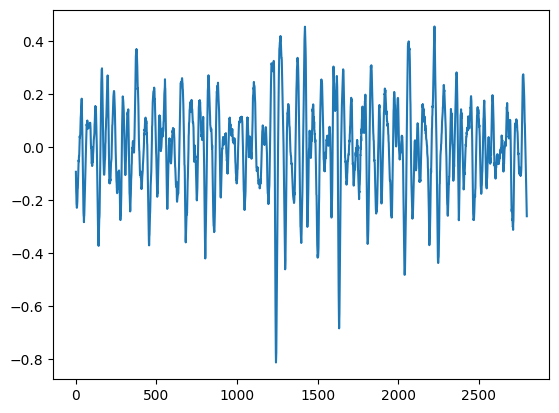

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2800),material[])